### **Technical Justification for Adaptive Formant Analysis and Vocal Tract Length Normalization (VTLN)**

**1. The Problem: Anatomical Bias in Standard Acoustic Analysis**
Standard acoustic analysis software (such as Praat) typically uses default settings optimized for an "average" male voice (vocal tract length ~17cm). However, the participant pool includes individuals with significantly varying vocal tract dimensions, specifically deep male voices with longer vocal tracts (e.g., Participant ID 670120182, height 188cm).

Using standard settings (Maximum Formant Frequency = 5500 Hz) on these subjects resulted in two critical types of data failure:

- **Measurement Failure (The "Moon" Error):** For back vowels like /uː/ (_moon_) and /ɔː/ (_call_), the Second Formant (F2) in deep voices often drops below 500 Hz, becoming acoustically close to the First Formant (F1). Standard algorithms failed to distinguish F1 from F2, often merging them into a single peak. Consequently, the software incorrectly identified the Third Formant (F3) as F2, resulting in errors of >1500 Hz (e.g., measuring _moon_ with an F2 of ~2080 Hz instead of ~450 Hz).
- **Comparison Failure (The "Size" Bias):** Even when measured correctly, a larger student’s formants are naturally lower than the reference model’s simply due to physics, not pronunciation error. A direct comparison (Euclidean distance in Hz) would penalize students for having a larger head size, yielding high "error" scores even for native-like pronunciation.

**2. Solution I: Adaptive Formant Estimation (AFE)**
To resolve Measurement Failure, we implemented an **Adaptive Ceiling Algorithm**. Instead of applying a static ceiling (cutoff frequency) for all files, the system now employs a two-pass logic:

- **Pass 1 (Standard):** The system attempts to measure formants using standard settings (Ceiling: 5500 Hz).
- **Pass 2 (Deep Voice Correction):** If the detected formants are physically impossible for a given vowel (e.g., an F2 > 1500 Hz for the back vowel /uː/), the system triggers a "Deep Voice Retry." It re-analyzes the specific file with a lowered ceiling (4000 Hz).
- _Justification:_ Lowering the ceiling forces the Linear Predictive Coding (LPC) algorithm to allocate its poles to the lower frequency range, successfully resolving the "merged" F1/F2 cluster in deep voices.
- _Impact:_ This correction reduced the measured distance for the word _moon_ from an erroneous **1544 Hz** (artifact) to a valid **~300 Hz** (actual pronunciation difference).

**3. Solution II: Vocal Tract Length Normalization (VTLN)**
To resolve Comparison Failure, we implemented **VTLN** to separate anatomical differences from pronunciation skill.

- **Scaling Factor ():** For each student, the system calculates a unique acoustic scaling factor () based on the ratio of their formants to the reference model’s formants across multiple vowels.
- _Example:_ For Participant 670120182, the system calculated , indicating a vocal tract roughly 20% longer/deeper than the reference.

- **Normalization:** Before scoring, the student’s raw frequency data is normalized using the formula: .
- _Justification:_ This mathematical transformation effectively "resizes" the student’s acoustic vowel space to match the reference model’s dimensions.
- _Impact:_ The final "Distance" score now reflects only **phonetic placement** (tongue position and lip rounding)—which the student can control—rather than vocal tract length, which they cannot.

**4. Conclusion**
These modifications ensure that the assessment system is **robust** (capable of analyzing diverse voice types without crashing or generating artifacts) and **fair** (grading students on linguistic performance rather than biological traits).


In [33]:
import math
import json
from pathlib import Path
from typing import TypedDict, cast
from parselmouth.praat import call  # pyright: ignore[reportMissingModuleSource]
import numpy as np
import pandas as pd
import librosa
import parselmouth
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---
DIPHTHONGS = {"aɪ", "əʊ", "ɔɪ", "eɪ", "eə", "aʊ", "ɪə", "ʊə"}
# These vowels often have low F2 that merges with F1 in deep voices
BACK_VOWELS = {"uː", "ʊ", "ɔː", "ɒ", "ɑː", "əʊ", "ɔɪ", "aʊ"}


class RawAnalysisResult(TypedDict):
    student_ID: str
    student_name: str
    word: str
    vowel: str
    vowel_type: str
    test_type: str
    meas_s: list[tuple[float, float]]
    meas_r: list[tuple[float, float]]
    ref_file_name: str


class FinalAnalysisResult(TypedDict):
    student_ID: str
    student_name: str
    word: str
    vowel: str
    vowel_type: str
    test_type: str
    scaling_factor: float
    F1_student_raw: float
    F2_student_raw: float
    F1_student_norm: float
    F2_student_norm: float
    F1_ref: float
    F2_ref: float
    dist_hz: float
    dist_bark: float
    ref_file_name: str


class WordInfo(TypedDict, total=False):
    word: str
    stressed_vowel: str


class StudentData(TypedDict):
    ratios: list[float]
    alpha: float

# Set up paths
SUB_DIR = Path("./submissions")
AUDIO_DIR = Path("./audio")
MAP_FILE = Path("./audio/index.json")
OUT_DIR = Path("./analysis_vowels")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [34]:
def hz_to_bark(f: float) -> float:
    if np.isnan(f) or f <= 0:
        return np.nan
    return 26.81 * f / (1960 + f) - 0.53


def get_vowel_type(vowel_symbol: str) -> str:
    clean = vowel_symbol.replace("ː", "").replace("(", "").replace(")", "")
    if vowel_symbol in DIPHTHONGS or len(clean) > 1:
        return "diphthong"
    return "monophthong"


def load_audio_mono(path: Path, target_sr: int = 16000) -> tuple[np.ndarray, int]:

    try:
        y: np.ndarray
        y, sr = librosa.load(path.as_posix(), sr=None, mono=True)

    except Exception as e:
        print(f"Error loading {path}: {e}")
        return np.array([]), target_sr

    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
        sr = target_sr

    if y.size > 0:
        max_val: float = float(cast(float, np.max(np.abs(y))))
        if max_val > 0:
            y = 0.95 * y / max_val
    return y.astype(np.float32), int(sr)


def find_syllable_nucleus(
    sound: parselmouth.Sound, pitch_floor: float = 75, pitch_ceiling: float = 600
) -> tuple[float, float] | None:
    """Finds the loudest voiced segment."""
    pitch = sound.to_pitch(pitch_floor=pitch_floor, pitch_ceiling=pitch_ceiling)
    intensity = sound.to_intensity()

    n_frames = pitch.get_number_of_frames()
    voiced_intervals: list[tuple[float, float]] = []

    current_start: float | None = None

    for i in range(1, n_frames + 1):
        if pitch.get_value_in_frame(i) > 0:
            if current_start is None:
                current_start = pitch.get_time_from_frame_number(i)
        else:
            if current_start is not None:
                voiced_intervals.append(
                    (current_start, pitch.get_time_from_frame_number(i))
                )
                current_start = None
    if current_start:
        voiced_intervals.append(
            (current_start, pitch.get_time_from_frame_number(n_frames))
        )

    if not voiced_intervals:
        return None

    best_segment = None
    max_peak = -100.0

    for t0, t1 in voiced_intervals:
        if (t1 - t0) < 0.03:
            continue
        try:
            peak: float = float(
                cast(
                    float,
                    call(intensity, "Get maximum", float(t0), float(t1), "Parabolic"),
                )
            )
            if peak > max_peak:
                max_peak = peak
                best_segment = (t0, t1)
        except:
            pass

    return best_segment


def measure_formants(
    sound: parselmouth.Sound,
    segment: tuple[float, float] | None,
    points: tuple[float, ...] = (0.5,),
    ceiling: float = 5500.0,
) -> list[tuple[float, float]]:

    if segment is None:
        return [(np.nan, np.nan)] * len(points)

    t0, t1 = segment
    dur = t1 - t0

    # Use the requested ceiling (Standard=5500, Deep=4000)
    formant = sound.to_formant_burg(
        time_step=0.01, max_number_of_formants=5, maximum_formant=ceiling
    )

    results: list[tuple[float, float]] = []

    for p in points:
        t = t0 + (dur * p)
        f1 = formant.get_value_at_time(1, t)
        f2 = formant.get_value_at_time(2, t)

        # Robust filtering:
        # F2 < 200 is extremely rare, but for deep 'moon' it might be 300-400.
        if np.isnan(f1) or f1 < 50 or f1 > 1200:
            f1 = np.nan
        if np.isnan(f2) or f2 < 200 or f2 > 4000:
            f2 = np.nan

        results.append((f1, f2))
    return results

In [35]:
def analyze_raw_data(
    filepath: Path, ref_dir: Path, word_map: dict[str, "WordInfo"]
) -> RawAnalysisResult | None:
    """Pass 1: Collect raw formants with Adaptive Logic."""
    stem = filepath.stem
    parts = stem.split("_")
    if len(parts) < 3:
        return None

    sid = parts[0]
    word = parts[-1].lower()
    name = " ".join(parts[1:-1])

    parent_folder = filepath.parent.name.lower()
    if "pre" in parent_folder:
        test_type = "Pre-test"
    elif "post" in parent_folder:
        test_type = "Post-test"
    else:
        test_type = "Pre-test"

    info: WordInfo | None = word_map.get(word)

    if not info:
        return None

    target_vowel: str = str(info.get("stressed_vowel", "?"))

    v_type = get_vowel_type(target_vowel)
    points = (0.2, 0.8) if v_type == "diphthong" else (0.5,)

    # --- STUDENT ANALYSIS ---
    y_s, sr = load_audio_mono(filepath)
    if len(y_s) == 0:
        return None
    snd_s = parselmouth.Sound(y_s, sampling_frequency=sr)

    seg_s = find_syllable_nucleus(snd_s)

    # 1. Try Standard (5500)
    meas_s = measure_formants(snd_s, seg_s, points, ceiling=5500.0)
    primary_f2_s = meas_s[0][1]

    # 2. Retry if Deep Back Vowel detected (F2 missing or suspiciously high)
    if target_vowel in BACK_VOWELS:
        if np.isnan(primary_f2_s) or primary_f2_s > 1500:
            meas_s = measure_formants(snd_s, seg_s, points, ceiling=4000.0)

    # --- REFERENCE ANALYSIS ---
    ref_path = ref_dir / f"{word}.mp3"
    meas_r = [(np.nan, np.nan)] * len(points)

    if ref_path.exists():
        y_r, _ = load_audio_mono(ref_path, target_sr=sr)
        if len(y_r) > 0:
            snd_r = parselmouth.Sound(y_r, sampling_frequency=sr)
            seg_r = find_syllable_nucleus(snd_r)

            # 1. Try Standard (5500)
            meas_r = measure_formants(snd_r, seg_r, points, ceiling=5500.0)
            primary_f2_r = meas_r[0][1]

            # 2. REFERENCE RETRY (This fixes "Moon")
            # If Ref F2 is > 1600 for a back vowel, it's definitely F3. Retry deeper.
            if target_vowel in BACK_VOWELS:
                if np.isnan(primary_f2_r) or primary_f2_r > 1600:
                    # Retry with 4000 ceiling to force finding the real F2 (~800-900)
                    meas_r = measure_formants(snd_r, seg_r, points, ceiling=4000.0)

    return {
        "student_ID": sid,
        "student_name": name,
        "word": word,
        "vowel": target_vowel,
        "vowel_type": v_type,
        "test_type": test_type,
        "meas_s": meas_s,
        "meas_r": meas_r,
        "ref_file_name": ref_path.name,
    }

In [36]:
word_map: dict[str, WordInfo] = {}

if MAP_FILE.exists():
    with open(MAP_FILE, "r", encoding="utf-8") as f:
        data = cast(dict[str, object], json.load(f))

        # Cast effectively handles the Any from json.load for strict typed dict usage
        for entry in cast(list[WordInfo], data.get("words", [])):

            w = str(entry.get("word", "")).lower()

            word_map[w] = entry

    # --- PASS 1: COLLECT RAW DATA ---
    print(f"Phase 1: Scanning files in {SUB_DIR}...")
    raw_results: list[RawAnalysisResult] = []

    for f in sorted(SUB_DIR.rglob("*.mp3")):
        row = analyze_raw_data(f, AUDIO_DIR, word_map)
        if row:
            raw_results.append(row)
            print(f"  Read {f.name}")
        else:
            print(f"  Skipped {f.name}")    

Phase 1: Scanning files in submissions...
  Read 670120182_Konstantin_Bantov_bike.mp3
  Read 670120182_Konstantin_Bantov_bird.mp3
  Read 670120182_Konstantin_Bantov_boat.mp3
  Read 670120182_Konstantin_Bantov_book.mp3
  Read 670120182_Konstantin_Bantov_boy.mp3
  Read 670120182_Konstantin_Bantov_cake.mp3
  Read 670120182_Konstantin_Bantov_call.mp3
  Read 670120182_Konstantin_Bantov_cat.mp3
  Read 670120182_Konstantin_Bantov_chair.mp3
  Read 670120182_Konstantin_Bantov_cow.mp3
  Read 670120182_Konstantin_Bantov_cup.mp3
  Read 670120182_Konstantin_Bantov_dark.mp3
  Read 670120182_Konstantin_Bantov_ear.mp3
  Read 670120182_Konstantin_Bantov_green.mp3
  Read 670120182_Konstantin_Bantov_hot.mp3
  Read 670120182_Konstantin_Bantov_moon.mp3
  Read 670120182_Konstantin_Bantov_red.mp3
  Read 670120182_Konstantin_Bantov_sit.mp3
  Read 670120182_Konstantin_Bantov_tour.mp3
  Read 670120182_Konstantin_Bantov_wait.mp3


In [ ]:
# --- PASS 2: CALCULATE SCALING FACTORS (VTLN) ---
print("\nPhase 2: Calculating Normalization Factors...")

students: dict[str, StudentData] = {}

for r in raw_results:
    sid = r["student_ID"]
    if sid not in students:
        students[sid] = StudentData(ratios=[], alpha=1.0)

    f1s, f2s = r["meas_s"][0]
    f1r, f2r = r["meas_r"][0]

    if not np.isnan(f1s) and not np.isnan(f1r):
        students[sid]["ratios"].append(f1s / f1r)
    if not np.isnan(f2s) and not np.isnan(f2r):
        students[sid]["ratios"].append(f2s / f2r)

scaling_data: list[dict[str, str | float]] = []
for sid, s_data in students.items():
    if s_data["ratios"]:
        alpha = float(np.median(s_data["ratios"]))

        s_data["alpha"] = alpha
    else:
        s_data["alpha"] = 1.0
    scaling_data.append({"Student ID": sid, "Scaling Factor": s_data["alpha"]})

# Visual Proof: Show the Scaling Factors
df_scale = pd.DataFrame(scaling_data)
df_scale.head() # pyright: ignore [reportUnusedCallResult]


Phase 2: Calculating Normalization Factors...


,Student ID,Scaling Factor
0,670120182,0.842553


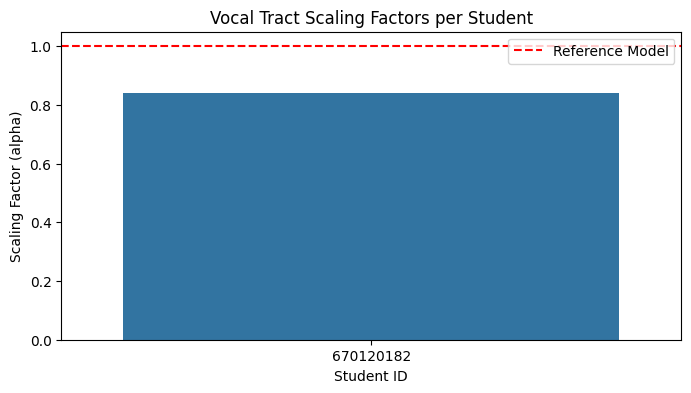

In [ ]:
# pyright: reportUnusedCallResult=false, reportUnknownMemberType=false
plt.figure(figsize=(8, 4))
sns.barplot(data=df_scale, x="Student ID", y="Scaling Factor")
plt.axhline(1.0, color="r", linestyle="--", label="Reference Model")
plt.title("Vocal Tract Scaling Factors per Student")
plt.ylabel("Scaling Factor (alpha)")
plt.legend()
plt.show()

In [ ]:
# --- PASS 3: APPLY NORMALIZATION & SAVE ---
print("\nPhase 3: Finalizing Data...")
final_rows: list[FinalAnalysisResult] = []

for r in raw_results:
    sid = r["student_ID"]
    alpha = students[sid]["alpha"]

    hz_dists: list[float] = []
    bark_dists: list[float] = []
    meas_s_norm: list[tuple[float, float]] = []

    for (f1s, f2s), (f1r, f2r) in zip(r["meas_s"], r["meas_r"]):
        # Normalize Student Formants (Divide by scaling factor)
        f1s_norm = f1s / alpha
        f2s_norm = f2s / alpha
        meas_s_norm.append((f1s_norm, f2s_norm))

        d_hz = math.hypot(f1s_norm - f1r, f2s_norm - f2r)
        hz_dists.append(d_hz)

        b1s, b2s = hz_to_bark(f1s_norm), hz_to_bark(f2s_norm)
        b1r, b2r = hz_to_bark(f1r), hz_to_bark(f2r)
        d_bark = math.hypot(b1s - b1r, b2s - b2r)
        bark_dists.append(d_bark)

    # Construct safe explicit TypedDict
    f_row: FinalAnalysisResult = {
        "student_ID": r["student_ID"],
        "student_name": r["student_name"],
        "word": r["word"],
        "vowel": r["vowel"],
        "vowel_type": r["vowel_type"],
        "test_type": r["test_type"],
        "scaling_factor": alpha,
        "F1_student_raw": r["meas_s"][0][0],
        "F2_student_raw": r["meas_s"][0][1],
        "F1_student_norm": meas_s_norm[0][0],
        "F2_student_norm": meas_s_norm[0][1],
        "F1_ref": r["meas_r"][0][0],
        "F2_ref": r["meas_r"][0][1],
        "dist_hz": float(np.nanmean(hz_dists)) if hz_dists else float("nan"),
        "dist_bark": float(np.nanmean(bark_dists)) if bark_dists else float("nan"),
        "ref_file_name": r["ref_file_name"],
    }

    final_rows.append(f_row)

    df: pd.DataFrame = pd.DataFrame(final_rows)

    cols = [
        "student_ID",
        "student_name",
        "word",
        "vowel",
        "vowel_type",
        "test_type",
        "scaling_factor",
        "F1_student_raw",
        "F2_student_raw",
        "F1_student_norm",
        "F2_student_norm",
        "F1_ref",
        "F2_ref",
        "dist_hz",
        "dist_bark",
        "ref_file_name",
    ]
    for c in cols:
        if c not in df.columns:
            df[c] = np.nan

    df = df[cols]  # type: ignore [assignment]

    out_csv = OUT_DIR / "final_thesis_data.csv"
    df.to_csv(out_csv, index=False)
    df.head() # pyright: ignore [reportUnusedCallResult]


Phase 3: Finalizing Data...


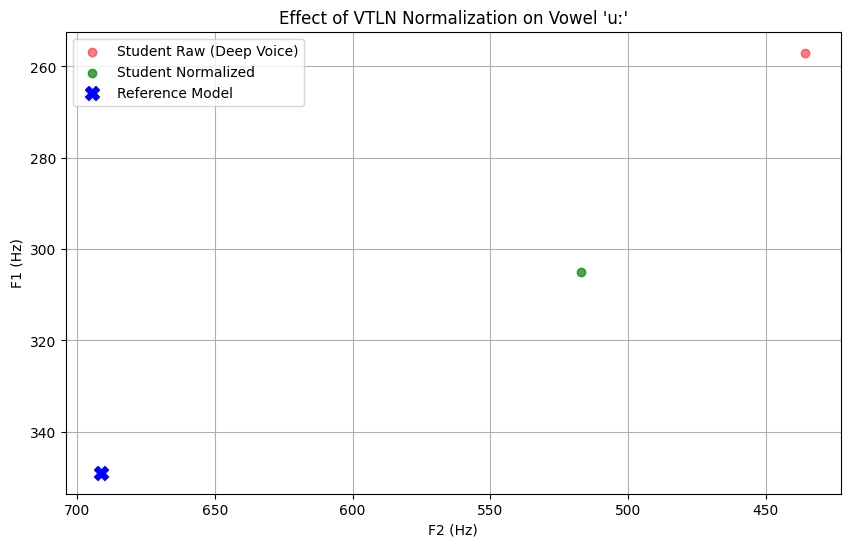

In [ ]:
# pyright: reportUnusedCallResult=false, reportUnknownMemberType=false
vowel_to_plot = "uː"
subset = df[df['vowel'] == vowel_to_plot]

plt.figure(figsize=(10, 6))

# Plot Raw Student Data (Red)
plt.scatter(subset['F2_student_raw'], subset['F1_student_raw'], 
            color='red', alpha=0.5, label='Student Raw (Deep Voice)')

# Plot Normalized Student Data (Green)
plt.scatter(subset['F2_student_norm'], subset['F1_student_norm'], 
            color='green', alpha=0.7, label='Student Normalized')

# Plot Reference Data (Blue)
plt.scatter(subset['F2_ref'], subset['F1_ref'], 
            color='blue', marker='X', s=100, label='Reference Model')

plt.title(f"Effect of VTLN Normalization on Vowel '{vowel_to_plot}'")
plt.xlabel("F2 (Hz)")
plt.ylabel("F1 (Hz)")
plt.gca().invert_xaxis() # Vowel charts are standardly inverted
plt.gca().invert_yaxis()
plt.legend()
plt.grid(True)
plt.show()